In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential,load_model
from tensorflow.keras.layers import Dense,Input,Dropout,Flatten
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.utils import shuffle
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import  BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPool2D

In [2]:

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/HUFS/train.csv', sep = ",")
df.head()

,subject,acc1_x,acc1_y,acc1_z,gyro1_x,gyro1_y,gyro1_z,acc2_x,acc2_y,acc2_z,label
0,3,-0.049573,0.051482,0.061498,0.357428,0.876525,-1.077288,0.951736,-0.303094,-0.133766,5
1,3,-0.085298,0.048648,0.083263,0.337020,0.840771,-1.329607,0.918129,-0.301953,-0.111281,5
2,3,-0.046568,0.057793,0.114970,0.320000,0.909147,-0.788201,0.958863,-0.288855,-0.078756,5
3,3,0.001564,0.068723,0.144465,0.308596,0.773221,-0.313850,1.008886,-0.274002,-0.048346,5
4,3,-0.026644,0.088834,0.188589,0.308176,0.691534,-0.457948,0.982454,-0.250003,-0.003217,5


In [4]:
df2 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/HUFS/test.csv', sep = ",")
df2.head()

,subject,acc1_x,acc1_y,acc1_z,gyro1_x,gyro1_y,gyro1_z,acc2_x,acc2_y,acc2_z,label
0,2,0.011653,-0.029399,0.106826,0.437464,0.531349,0.136528,1.041216,-0.269796,0.023780,5
1,2,0.013109,-0.039729,0.152455,0.468264,0.721069,0.097622,1.041803,-0.280025,0.076293,5
2,2,0.011269,-0.052406,0.216846,0.498257,0.520328,0.083556,1.039086,-0.292663,0.147475,5
3,2,0.027831,-0.052106,0.202581,0.479396,0.372625,0.022861,1.054768,-0.292384,0.139906,5
4,2,0.002318,-0.045470,0.176010,0.389894,0.414541,-0.025939,1.028376,-0.285826,0.119934,5


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 528256 entries, 0 to 528255
Data columns (total 11 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   subject  528256 non-null  int64  
 1   acc1_x   528256 non-null  float64
 2   acc1_y   528256 non-null  float64
 3   acc1_z   528256 non-null  float64
 4   gyro1_x  528256 non-null  float64
 5   gyro1_y  528256 non-null  float64
 6   gyro1_z  528256 non-null  float64
 7   acc2_x   528256 non-null  float64
 8   acc2_y   528256 non-null  float64
 9   acc2_z   528256 non-null  float64
 10  label    528256 non-null  int64  
dtypes: float64(9), int64(2)
memory usage: 44.3 MB


In [6]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 263424 entries, 0 to 263423
Data columns (total 11 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   subject  263424 non-null  int64  
 1   acc1_x   263424 non-null  float64
 2   acc1_y   263424 non-null  float64
 3   acc1_z   263424 non-null  float64
 4   gyro1_x  263424 non-null  float64
 5   gyro1_y  263424 non-null  float64
 6   gyro1_z  263424 non-null  float64
 7   acc2_x   263424 non-null  float64
 8   acc2_y   263424 non-null  float64
 9   acc2_z   263424 non-null  float64
 10  label    263424 non-null  int64  
dtypes: float64(9), int64(2)
memory usage: 22.1 MB


In [7]:
df['label'] -= 1;
df2['label'] -= 1;

In [8]:
y_train = df[['label', 'subject']]
X_train = df.drop(['label'],axis=1)
y_test = df2[['label', 'subject']]
X_test = df2.drop(['label'],axis=1)

In [9]:
epochs = 25
batch_size = 64
num_classes = 6
fig_size = (9,7)
frame_size = 80
hop_size = 40

In [10]:
# FUNCTIONS-
import scipy.stats as stats
def get_frames(df, frame_size, hop_size):

    N_FEATURES = 9

    frames = []
    labels = []
    for i in range(0, len(df) - frame_size, hop_size):
        acc1_x = df['acc1_x'].values[i: i + frame_size]
        acc1_y = df['acc1_y'].values[i: i + frame_size]
        acc1_z = df['acc1_z'].values[i: i + frame_size]
        gyro1_x = df['gyro1_x'].values[i: i + frame_size]
        gyro1_y = df['gyro1_y'].values[i: i + frame_size]
        gyro1_z = df['gyro1_z'].values[i: i + frame_size]
        acc2_x = df['acc2_x'].values[i: i + frame_size]
        acc2_y = df['acc2_y'].values[i: i + frame_size]
        acc2_z = df['acc2_z'].values[i: i + frame_size]
        
        label = stats.mode(df['label'][i: i + frame_size])[0][0]
        frames.append([acc1_x, acc1_y,	acc1_z,	gyro1_x,	gyro1_y,	gyro1_z,	acc2_x,	acc2_y,	acc2_z])
        labels.append(label)

    
    frames = np.asarray(frames).reshape(-1, frame_size, N_FEATURES)
    labels = np.asarray(labels)

    return frames, labels

def PREPROCESS(X , y):
    scaler = MinMaxScaler()
    scaler.fit(X)
    X = scaler.transform(X)
    y = np.array(y)
    scaled_df = pd.DataFrame(data = X, columns = ['acc1_x', 'acc1_y', 'acc1_z', 'gyro1_x',	'gyro1_y'	,'gyro1_z',	'acc2_x',	'acc2_y'	,'acc2_z'])
    scaled_df['label'] = y
    X, y = get_frames(scaled_df, frame_size, hop_size)
    X = X.reshape(X.shape[0], 80, 9, 1)
    return X,y

def CREATE_MODEL(X_train):
    model = Sequential()
    model.add(Conv2D(16, (2, 2), activation = 'relu', input_shape = X_train[0].shape))
    model.add(Dropout(0.1))

    model.add(Conv2D(32, (2, 2), activation='relu'))
    model.add(Dropout(0.2))

    model.add(Flatten())

    model.add(Dense(64, activation = 'relu'))
    model.add(Dropout(0.5))

    model.add(Dense(6, activation='softmax'))
    return model

def COMPILE(model):
    model.compile(
    optimizer=Adam(learning_rate = 0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
    )
    return model;
    
def FIT(model,X,y,i):
    history = model.fit(
    X,
    y,
    validation_split=0.2,
    batch_size=batch_size,
    epochs=epochs,
    callbacks=[
        tf.keras.callbacks.ModelCheckpoint(f'./model_{i}.h5', save_best_only=True),
        tf.keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.1,
            patience=1
        )
    ],
    verbose=1
    )
    return history,model

def PLOT(history,i):
    epochs_range = range(epochs)
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    train_acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    
    plt.figure(figsize=fig_size)
    plt.plot(epochs_range,train_loss,label="Training Loss")
    plt.plot(epochs_range,val_loss,label="Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.title(f"Model {i} - Loss Over Time")
    plt.show()
    
    plt.figure(figsize=fig_size)
    plt.plot(epochs_range,train_acc,label="Training accuracy")
    plt.plot(epochs_range,val_acc,label="Validation accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("accuracy")
    plt.legend()
    plt.title(f"Model {i} - Accuracy")
    plt.show()

def CONFUSION_MATRIX(y_test, y_pred):
    confusionMatrix = confusion_matrix(y_test, y_pred)
    sns.set(font_scale=1.5)
    labels = ["WALKING", "WALKING_UPSTAIRS", "WALKING_DOWNSTAIRS", "SITTING", "STANDING", "LYING"]
    plt.figure(figsize=(16,7))
    sns.heatmap(confusionMatrix, cmap = "Blues", annot = True, fmt = ".0f", xticklabels=labels, yticklabels=labels)
    plt.title("Global Model Confusion Matrix", fontsize = 30)
    plt.xlabel('Predicted Class', fontsize = 20)
    plt.ylabel('Original Class', fontsize = 20)
    plt.tick_params(labelsize = 15)
    plt.xticks(rotation = 45)
    plt.show()
    
def LOAD_MODELS():
    for i in range(1,15):
        model = load_model(f'./model_{i}.h5')
        all_models.append(model)

def APPLY_WEIGHT_FUNCTION(weights):
    avg_model_weights = []
    n_models = len(all_models)
    n_layers = len(all_models[0].get_weights())
    for layer in range(n_layers):
        layer_weights = np.array([model.get_weights()[layer] for model in all_models])
        avg_layer_weights = np.average(layer_weights, axis=0, weights=weights)
        avg_model_weights.append(avg_layer_weights)
    return avg_model_weights;

Epoch 1/25
14/14 [==============================] - 2s 80ms/step - loss: 1.5808 - accuracy: 0.3496 - val_loss: 1.9548 - val_accuracy: 0.0000e+00
Epoch 2/25
14/14 [==============================] - 1s 69ms/step - loss: 1.2785 - accuracy: 0.4690 - val_loss: 1.9555 - val_accuracy: 0.1619
Epoch 3/25
14/14 [==============================] - 1s 69ms/step - loss: 1.1582 - accuracy: 0.5000 - val_loss: 1.8861 - val_accuracy: 0.1667
Epoch 4/25
14/14 [==============================] - 1s 70ms/step - loss: 1.1228 - accuracy: 0.5322 - val_loss: 1.8954 - val_accuracy: 0.0381
Epoch 5/25
14/14 [==============================] - 1s 67ms/step - loss: 1.1236 - accuracy: 0.5442 - val_loss: 1.8942 - val_accuracy: 0.0286
Epoch 6/25
14/14 [==============================] - 1s 68ms/step - loss: 1.1065 - accuracy: 0.5453 - val_loss: 1.8933 - val_accuracy: 0.0381
Epoch 7/25
14/14 [==============================] - 1s 68ms/step - loss: 1.1221 - accuracy: 0.5263 - val_loss: 1.8932 - val_accuracy: 0.0381
Epoch 8/2

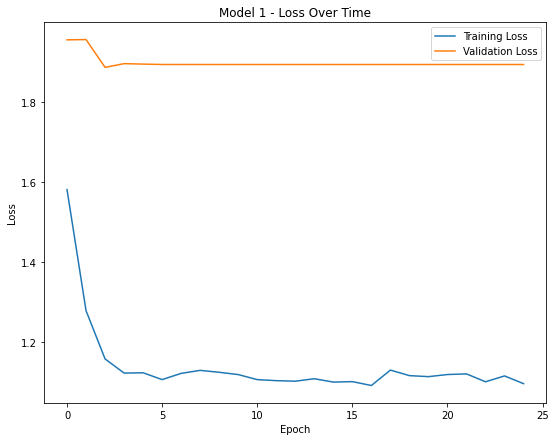

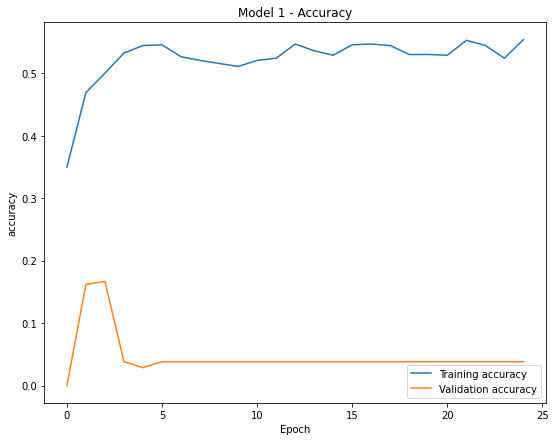

Epoch 1/25
13/13 [==============================] - 2s 80ms/step - loss: 1.6517 - accuracy: 0.3094 - val_loss: 1.8274 - val_accuracy: 0.2663
Epoch 2/25
13/13 [==============================] - 1s 70ms/step - loss: 1.3197 - accuracy: 0.4478 - val_loss: 1.8457 - val_accuracy: 0.0000e+00
Epoch 3/25
13/13 [==============================] - 1s 71ms/step - loss: 1.1888 - accuracy: 0.4855 - val_loss: 1.7576 - val_accuracy: 0.0050
Epoch 4/25
13/13 [==============================] - 1s 69ms/step - loss: 1.1578 - accuracy: 0.5132 - val_loss: 1.7060 - val_accuracy: 0.0050
Epoch 5/25
13/13 [==============================] - 1s 72ms/step - loss: 1.1268 - accuracy: 0.5270 - val_loss: 1.6339 - val_accuracy: 0.2060
Epoch 6/25
13/13 [==============================] - 1s 69ms/step - loss: 1.0948 - accuracy: 0.5434 - val_loss: 1.6367 - val_accuracy: 0.0101
Epoch 7/25
13/13 [==============================] - 1s 69ms/step - loss: 1.0742 - accuracy: 0.5547 - val_loss: 1.6282 - val_accuracy: 0.0251
Epoch 8/2

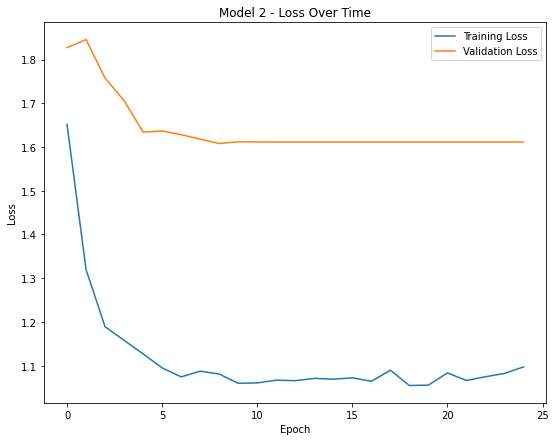

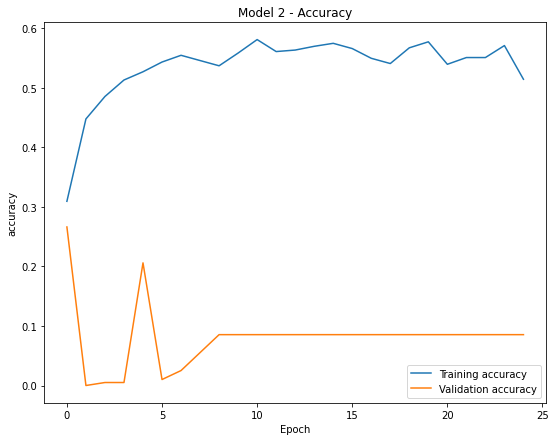

Epoch 1/25
10/10 [==============================] - 1s 85ms/step - loss: 1.6754 - accuracy: 0.3115 - val_loss: 1.9186 - val_accuracy: 0.0000e+00
Epoch 2/25
10/10 [==============================] - 1s 68ms/step - loss: 1.3770 - accuracy: 0.4623 - val_loss: 1.8385 - val_accuracy: 0.0000e+00
Epoch 3/25
10/10 [==============================] - 1s 69ms/step - loss: 1.1524 - accuracy: 0.5131 - val_loss: 1.5671 - val_accuracy: 0.2222
Epoch 4/25
10/10 [==============================] - 1s 70ms/step - loss: 1.0195 - accuracy: 0.5705 - val_loss: 1.4929 - val_accuracy: 0.4183
Epoch 5/25
10/10 [==============================] - 1s 69ms/step - loss: 0.8728 - accuracy: 0.6230 - val_loss: 1.3350 - val_accuracy: 0.4183
Epoch 6/25
10/10 [==============================] - 1s 69ms/step - loss: 0.7442 - accuracy: 0.6918 - val_loss: 1.2278 - val_accuracy: 0.4118
Epoch 7/25
10/10 [==============================] - 1s 76ms/step - loss: 0.7461 - accuracy: 0.6508 - val_loss: 1.3496 - val_accuracy: 0.4052
Epoch

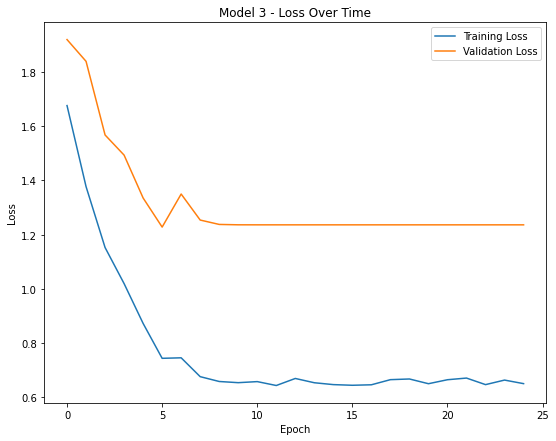

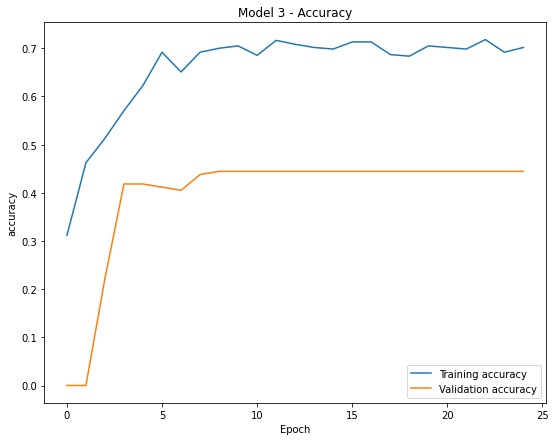

Epoch 1/25
9/9 [==============================] - 1s 88ms/step - loss: 1.7363 - accuracy: 0.2629 - val_loss: 2.0158 - val_accuracy: 0.0000e+00
Epoch 2/25
9/9 [==============================] - 1s 69ms/step - loss: 1.5749 - accuracy: 0.4044 - val_loss: 1.9357 - val_accuracy: 0.3235
Epoch 3/25
9/9 [==============================] - 1s 70ms/step - loss: 1.4371 - accuracy: 0.3897 - val_loss: 2.0597 - val_accuracy: 0.0882
Epoch 4/25
9/9 [==============================] - 1s 72ms/step - loss: 1.3454 - accuracy: 0.4651 - val_loss: 2.0082 - val_accuracy: 0.0000e+00
Epoch 5/25
9/9 [==============================] - 1s 71ms/step - loss: 1.3227 - accuracy: 0.4522 - val_loss: 2.0032 - val_accuracy: 0.0000e+00
Epoch 6/25
9/9 [==============================] - 1s 70ms/step - loss: 1.3206 - accuracy: 0.4926 - val_loss: 2.0025 - val_accuracy: 0.0000e+00
Epoch 7/25
9/9 [==============================] - 1s 73ms/step - loss: 1.3076 - accuracy: 0.4669 - val_loss: 2.0024 - val_accuracy: 0.0000e+00
Epoch 8

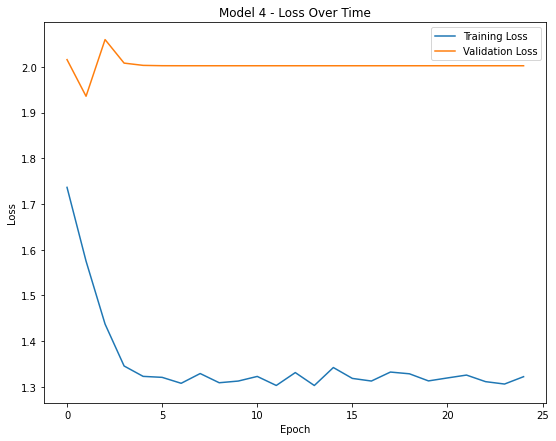

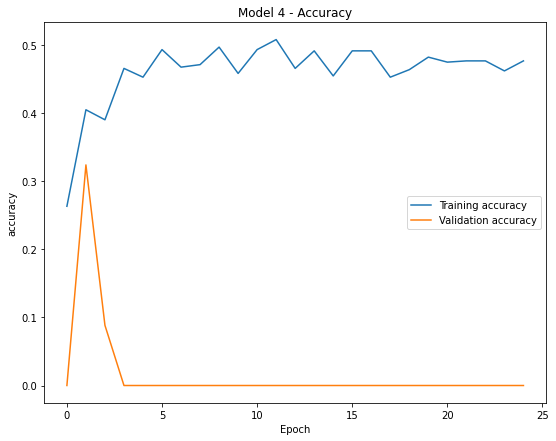

Epoch 1/25
13/13 [==============================] - 1s 83ms/step - loss: 1.5990 - accuracy: 0.3829 - val_loss: 2.0237 - val_accuracy: 0.0000e+00
Epoch 2/25
13/13 [==============================] - 1s 73ms/step - loss: 1.2412 - accuracy: 0.5207 - val_loss: 1.8273 - val_accuracy: 0.0000e+00
Epoch 3/25
13/13 [==============================] - 1s 72ms/step - loss: 1.0533 - accuracy: 0.6049 - val_loss: 1.7797 - val_accuracy: 0.0437
Epoch 4/25
13/13 [==============================] - 1s 73ms/step - loss: 0.9091 - accuracy: 0.6232 - val_loss: 1.4498 - val_accuracy: 0.3495
Epoch 5/25
13/13 [==============================] - 1s 73ms/step - loss: 0.7782 - accuracy: 0.6988 - val_loss: 1.1340 - val_accuracy: 0.6942
Epoch 6/25
13/13 [==============================] - 1s 76ms/step - loss: 0.6452 - accuracy: 0.7427 - val_loss: 1.0996 - val_accuracy: 0.7136
Epoch 7/25
13/13 [==============================] - 1s 73ms/step - loss: 0.5799 - accuracy: 0.7732 - val_loss: 0.8662 - val_accuracy: 0.7282
Epoch

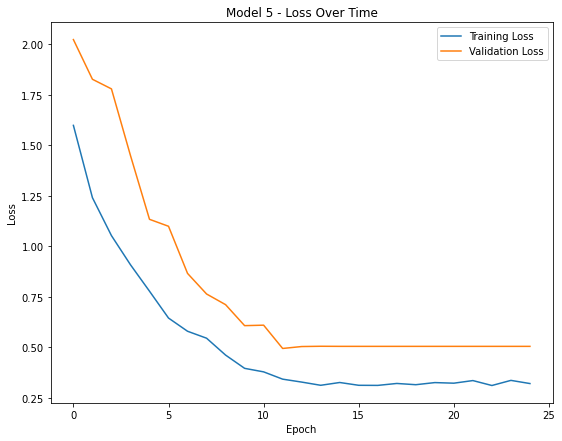

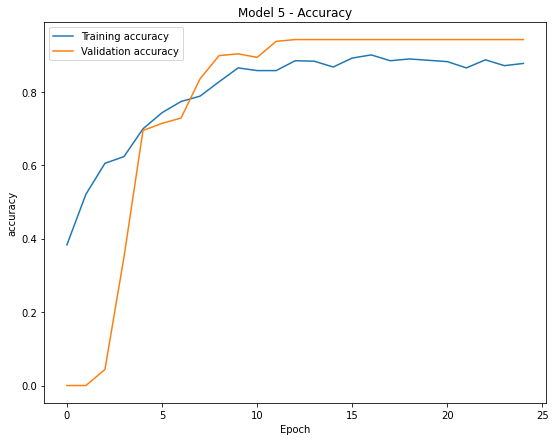

Epoch 1/25
14/14 [==============================] - 2s 88ms/step - loss: 1.5762 - accuracy: 0.3600 - val_loss: 2.0991 - val_accuracy: 0.0000e+00
Epoch 2/25
14/14 [==============================] - 1s 77ms/step - loss: 1.2259 - accuracy: 0.5309 - val_loss: 2.2668 - val_accuracy: 0.0000e+00
Epoch 3/25
14/14 [==============================] - 1s 75ms/step - loss: 1.1018 - accuracy: 0.5501 - val_loss: 2.1969 - val_accuracy: 0.0000e+00
Epoch 4/25
14/14 [==============================] - 1s 76ms/step - loss: 1.0684 - accuracy: 0.5692 - val_loss: 2.1996 - val_accuracy: 0.0000e+00
Epoch 5/25
14/14 [==============================] - 1s 76ms/step - loss: 1.0707 - accuracy: 0.5759 - val_loss: 2.1994 - val_accuracy: 0.0000e+00
Epoch 6/25
14/14 [==============================] - 1s 76ms/step - loss: 1.0773 - accuracy: 0.5647 - val_loss: 2.1993 - val_accuracy: 0.0000e+00
Epoch 7/25
14/14 [==============================] - 1s 76ms/step - loss: 1.0672 - accuracy: 0.5658 - val_loss: 2.1993 - val_accura

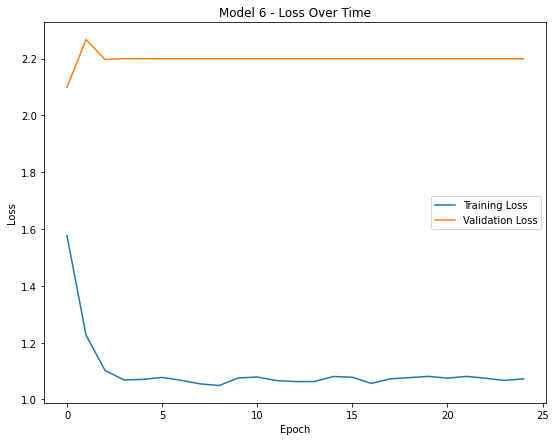

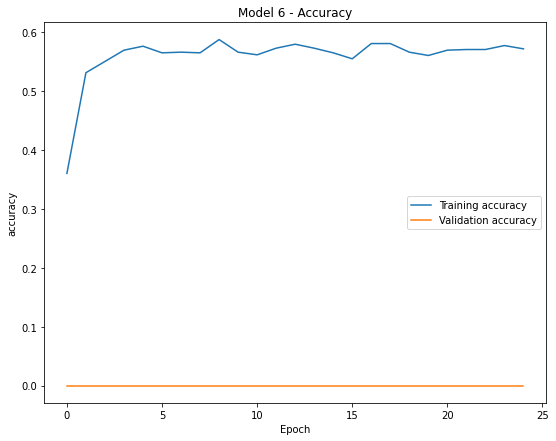

Epoch 1/25
15/15 [==============================] - 2s 79ms/step - loss: 1.5425 - accuracy: 0.3958 - val_loss: 2.1349 - val_accuracy: 0.0000e+00
Epoch 2/25
15/15 [==============================] - 1s 71ms/step - loss: 1.2127 - accuracy: 0.5033 - val_loss: 2.1253 - val_accuracy: 0.0000e+00
Epoch 3/25
15/15 [==============================] - 1s 71ms/step - loss: 1.0609 - accuracy: 0.5621 - val_loss: 2.0346 - val_accuracy: 0.0000e+00
Epoch 4/25
15/15 [==============================] - 1s 70ms/step - loss: 0.9479 - accuracy: 0.5654 - val_loss: 1.8379 - val_accuracy: 0.0088
Epoch 5/25
15/15 [==============================] - 1s 71ms/step - loss: 0.8102 - accuracy: 0.6563 - val_loss: 1.7717 - val_accuracy: 0.1637
Epoch 6/25
15/15 [==============================] - 1s 69ms/step - loss: 0.7634 - accuracy: 0.6896 - val_loss: 1.6858 - val_accuracy: 0.3053
Epoch 7/25
15/15 [==============================] - 1s 70ms/step - loss: 0.7217 - accuracy: 0.6951 - val_loss: 1.6698 - val_accuracy: 0.2389
E

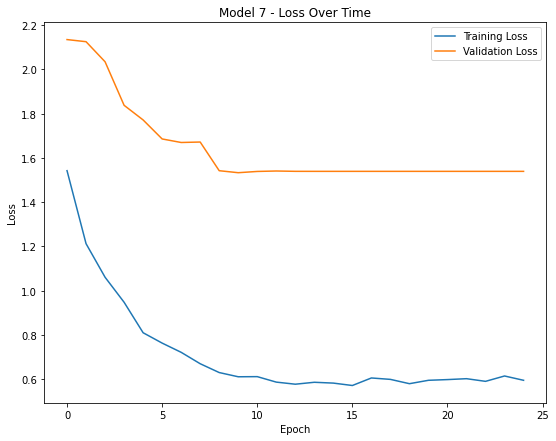

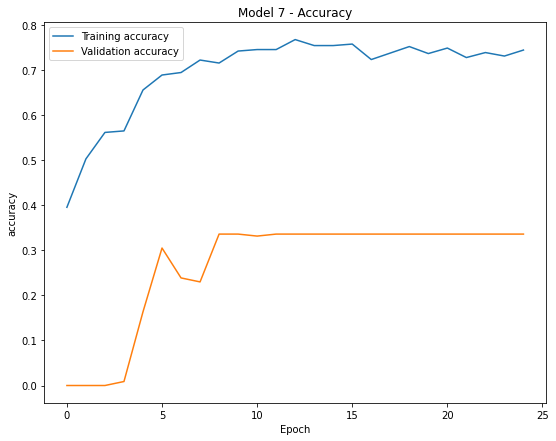

Epoch 1/25
14/14 [==============================] - 2s 86ms/step - loss: 1.6200 - accuracy: 0.3507 - val_loss: 2.0794 - val_accuracy: 0.0000e+00
Epoch 2/25
14/14 [==============================] - 1s 74ms/step - loss: 1.2711 - accuracy: 0.4665 - val_loss: 1.9786 - val_accuracy: 0.0000e+00
Epoch 3/25
14/14 [==============================] - 1s 77ms/step - loss: 1.0758 - accuracy: 0.5403 - val_loss: 1.9095 - val_accuracy: 0.0000e+00
Epoch 4/25
14/14 [==============================] - 1s 74ms/step - loss: 0.9236 - accuracy: 0.5857 - val_loss: 1.5434 - val_accuracy: 0.4842
Epoch 5/25
14/14 [==============================] - 1s 75ms/step - loss: 0.8383 - accuracy: 0.6390 - val_loss: 1.7117 - val_accuracy: 0.2353
Epoch 6/25
14/14 [==============================] - 1s 76ms/step - loss: 0.7568 - accuracy: 0.6538 - val_loss: 1.4871 - val_accuracy: 0.3439
Epoch 7/25
14/14 [==============================] - 1s 78ms/step - loss: 0.7508 - accuracy: 0.6754 - val_loss: 1.5075 - val_accuracy: 0.3394
E

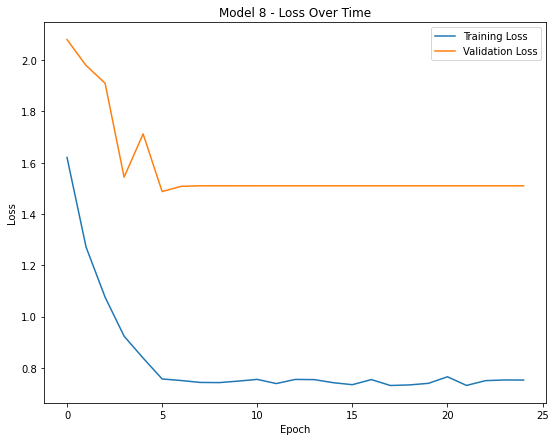

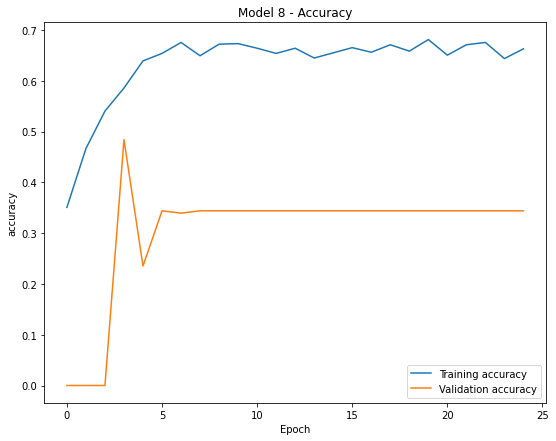

Epoch 1/25
14/14 [==============================] - 2s 87ms/step - loss: 1.5599 - accuracy: 0.3837 - val_loss: 1.9783 - val_accuracy: 0.1357
Epoch 2/25
14/14 [==============================] - 1s 77ms/step - loss: 1.2001 - accuracy: 0.5392 - val_loss: 1.7566 - val_accuracy: 0.1357
Epoch 3/25
14/14 [==============================] - 1s 79ms/step - loss: 1.0136 - accuracy: 0.6300 - val_loss: 1.7385 - val_accuracy: 0.1357
Epoch 4/25
14/14 [==============================] - 1s 79ms/step - loss: 0.9264 - accuracy: 0.6186 - val_loss: 1.6112 - val_accuracy: 0.1357
Epoch 5/25
14/14 [==============================] - 1s 77ms/step - loss: 0.8041 - accuracy: 0.6913 - val_loss: 1.5267 - val_accuracy: 0.1584
Epoch 6/25
14/14 [==============================] - 1s 73ms/step - loss: 0.6998 - accuracy: 0.7344 - val_loss: 1.3277 - val_accuracy: 0.3620
Epoch 7/25
14/14 [==============================] - 1s 74ms/step - loss: 0.6435 - accuracy: 0.7537 - val_loss: 1.3276 - val_accuracy: 0.3394
Epoch 8/25
14

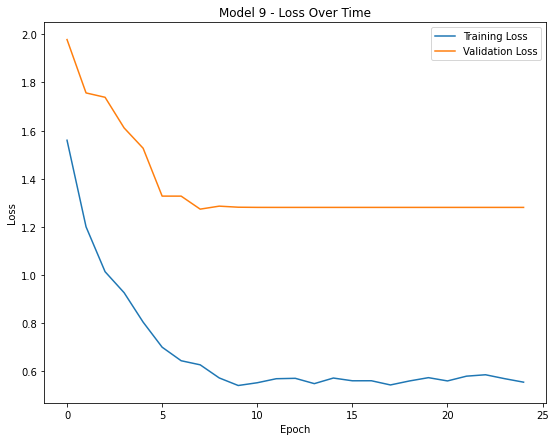

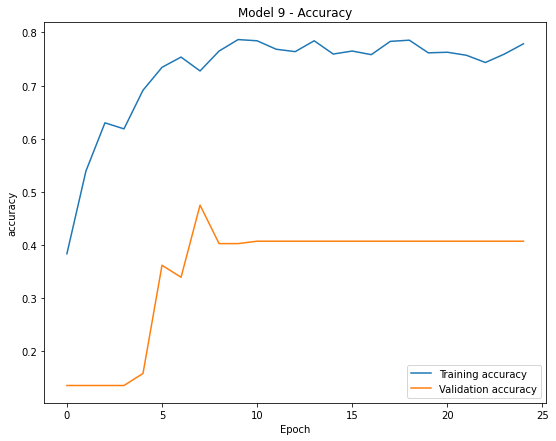

Epoch 1/25
14/14 [==============================] - 2s 83ms/step - loss: 1.5883 - accuracy: 0.3820 - val_loss: 2.1385 - val_accuracy: 0.0000e+00
Epoch 2/25
14/14 [==============================] - 1s 71ms/step - loss: 1.2165 - accuracy: 0.5339 - val_loss: 2.1184 - val_accuracy: 0.0000e+00
Epoch 3/25
14/14 [==============================] - 1s 74ms/step - loss: 1.0378 - accuracy: 0.5748 - val_loss: 1.8771 - val_accuracy: 0.0748
Epoch 4/25
14/14 [==============================] - 1s 73ms/step - loss: 0.8841 - accuracy: 0.6262 - val_loss: 1.8916 - val_accuracy: 0.0888
Epoch 5/25
14/14 [==============================] - 1s 73ms/step - loss: 0.7968 - accuracy: 0.6694 - val_loss: 1.8245 - val_accuracy: 0.1402
Epoch 6/25
14/14 [==============================] - 1s 74ms/step - loss: 0.7639 - accuracy: 0.6741 - val_loss: 1.7666 - val_accuracy: 0.2430
Epoch 7/25
14/14 [==============================] - 1s 78ms/step - loss: 0.7358 - accuracy: 0.6822 - val_loss: 1.8203 - val_accuracy: 0.1916
Epoch

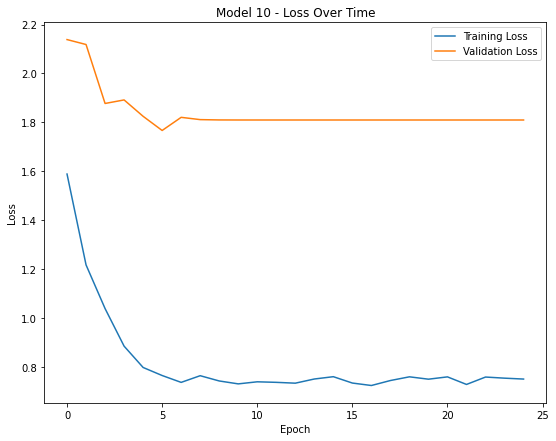

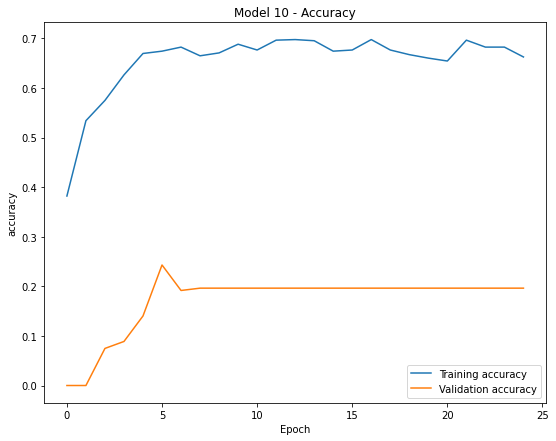

Epoch 1/25
10/10 [==============================] - 1s 91ms/step - loss: 1.6276 - accuracy: 0.3949 - val_loss: 1.7650 - val_accuracy: 0.0629
Epoch 2/25
10/10 [==============================] - 1s 77ms/step - loss: 1.2119 - accuracy: 0.5245 - val_loss: 1.9005 - val_accuracy: 0.0566
Epoch 3/25
10/10 [==============================] - 1s 76ms/step - loss: 1.0892 - accuracy: 0.5940 - val_loss: 1.8357 - val_accuracy: 0.0629
Epoch 4/25
10/10 [==============================] - 1s 79ms/step - loss: 1.0639 - accuracy: 0.6256 - val_loss: 1.8296 - val_accuracy: 0.0629
Epoch 5/25
10/10 [==============================] - 1s 79ms/step - loss: 1.0651 - accuracy: 0.6224 - val_loss: 1.8287 - val_accuracy: 0.0629
Epoch 6/25
10/10 [==============================] - 1s 79ms/step - loss: 1.0761 - accuracy: 0.6177 - val_loss: 1.8286 - val_accuracy: 0.0629
Epoch 7/25
10/10 [==============================] - 1s 81ms/step - loss: 1.0440 - accuracy: 0.6240 - val_loss: 1.8286 - val_accuracy: 0.0629
Epoch 8/25
10

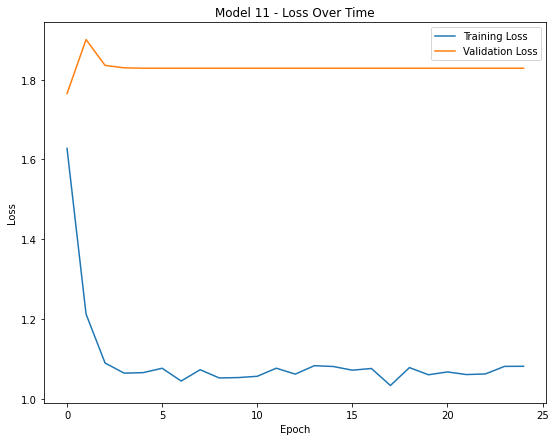

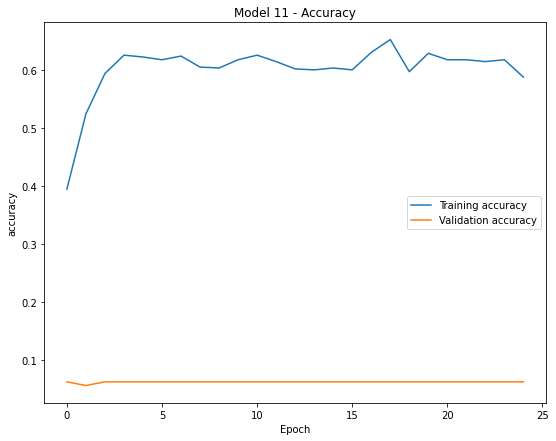

Epoch 1/25
8/8 [==============================] - 1s 89ms/step - loss: 1.6651 - accuracy: 0.3296 - val_loss: 1.9440 - val_accuracy: 0.0177
Epoch 2/25
8/8 [==============================] - 1s 70ms/step - loss: 1.4445 - accuracy: 0.4558 - val_loss: 1.9874 - val_accuracy: 0.0177
Epoch 3/25
8/8 [==============================] - 1s 74ms/step - loss: 1.3571 - accuracy: 0.4336 - val_loss: 1.9450 - val_accuracy: 0.0177
Epoch 4/25
8/8 [==============================] - 1s 71ms/step - loss: 1.3024 - accuracy: 0.4779 - val_loss: 1.9429 - val_accuracy: 0.0177
Epoch 5/25
8/8 [==============================] - 1s 73ms/step - loss: 1.2860 - accuracy: 0.5022 - val_loss: 1.9417 - val_accuracy: 0.0177
Epoch 6/25
8/8 [==============================] - 1s 75ms/step - loss: 1.2962 - accuracy: 0.4912 - val_loss: 1.9419 - val_accuracy: 0.0177
Epoch 7/25
8/8 [==============================] - 1s 72ms/step - loss: 1.3002 - accuracy: 0.4690 - val_loss: 1.9418 - val_accuracy: 0.0177
Epoch 8/25
8/8 [===========

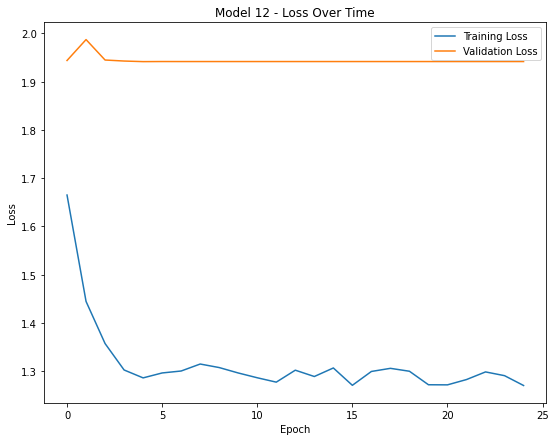

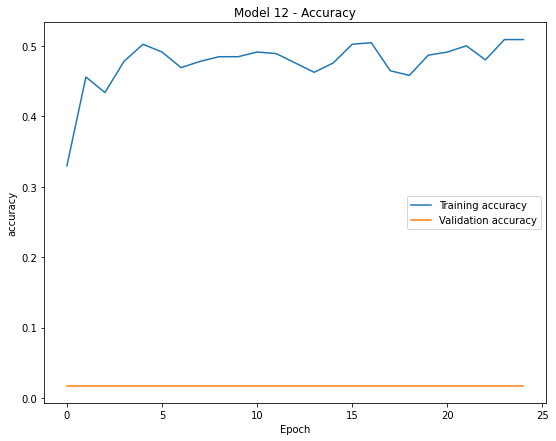

Epoch 1/25
10/10 [==============================] - 1s 86ms/step - loss: 1.7295 - accuracy: 0.3025 - val_loss: 2.1789 - val_accuracy: 0.0000e+00
Epoch 2/25
10/10 [==============================] - 1s 71ms/step - loss: 1.4568 - accuracy: 0.4437 - val_loss: 2.0003 - val_accuracy: 0.0000e+00
Epoch 3/25
10/10 [==============================] - 1s 72ms/step - loss: 1.2737 - accuracy: 0.5160 - val_loss: 2.1865 - val_accuracy: 0.0000e+00
Epoch 4/25
10/10 [==============================] - 1s 73ms/step - loss: 1.1918 - accuracy: 0.5479 - val_loss: 2.1461 - val_accuracy: 0.0000e+00
Epoch 5/25
10/10 [==============================] - 1s 74ms/step - loss: 1.1792 - accuracy: 0.5395 - val_loss: 2.1430 - val_accuracy: 0.0000e+00
Epoch 6/25
10/10 [==============================] - 1s 76ms/step - loss: 1.1744 - accuracy: 0.5496 - val_loss: 2.1427 - val_accuracy: 0.0000e+00
Epoch 7/25
10/10 [==============================] - 1s 73ms/step - loss: 1.2048 - accuracy: 0.5479 - val_loss: 2.1426 - val_accura

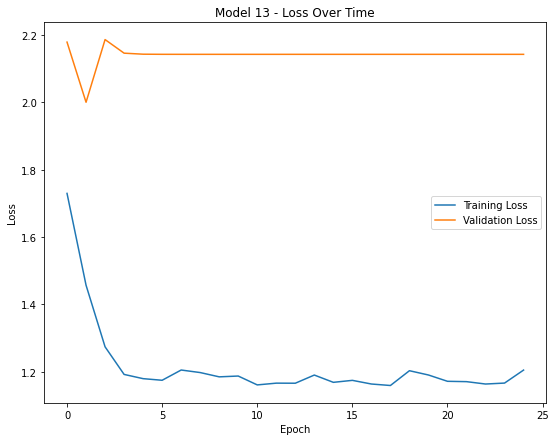

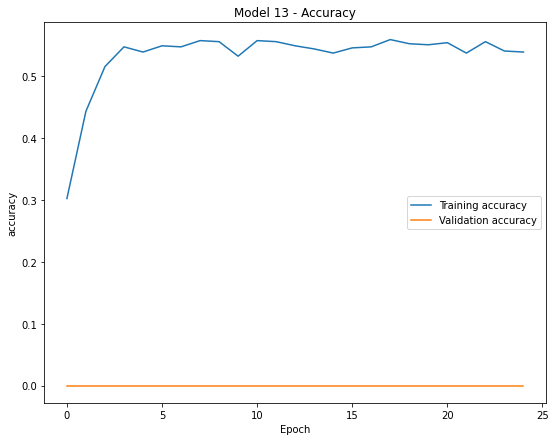

Epoch 1/25
14/14 [==============================] - 2s 82ms/step - loss: 1.5664 - accuracy: 0.3286 - val_loss: 1.9376 - val_accuracy: 0.0000e+00
Epoch 2/25
14/14 [==============================] - 1s 76ms/step - loss: 1.1336 - accuracy: 0.5591 - val_loss: 1.6991 - val_accuracy: 0.4528
Epoch 3/25
14/14 [==============================] - 1s 75ms/step - loss: 0.7815 - accuracy: 0.6974 - val_loss: 1.4057 - val_accuracy: 0.4906
Epoch 4/25
14/14 [==============================] - 1s 76ms/step - loss: 0.6464 - accuracy: 0.7423 - val_loss: 1.2272 - val_accuracy: 0.7736
Epoch 5/25
14/14 [==============================] - 1s 76ms/step - loss: 0.5314 - accuracy: 0.7931 - val_loss: 1.0420 - val_accuracy: 0.8113
Epoch 6/25
14/14 [==============================] - 1s 75ms/step - loss: 0.4659 - accuracy: 0.8215 - val_loss: 0.8756 - val_accuracy: 0.8019
Epoch 7/25
14/14 [==============================] - 1s 76ms/step - loss: 0.3513 - accuracy: 0.8771 - val_loss: 0.6446 - val_accuracy: 0.8632
Epoch 8/2

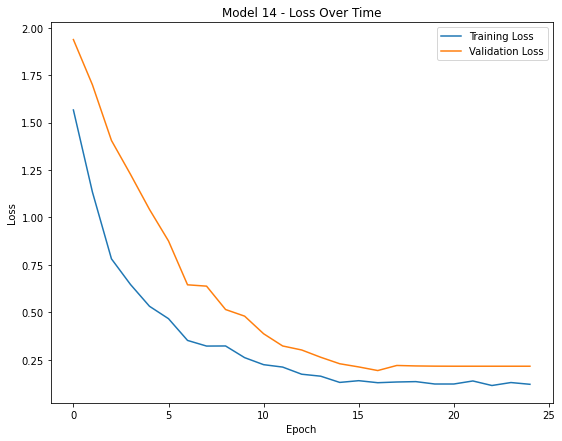

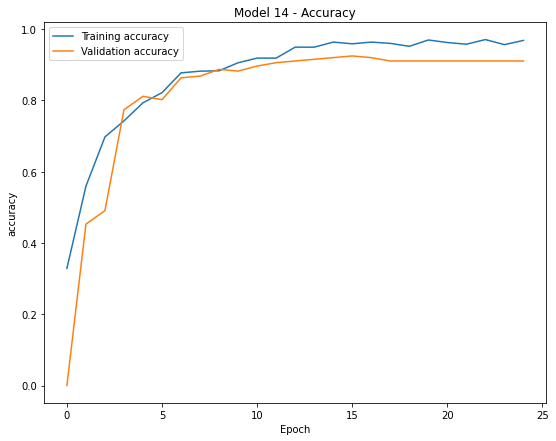

In [11]:
X_train_1 = X_train[X_train['subject'] == 3]
y_train_1 = y_train[y_train['subject'] == 3]
X_train_1 = X_train_1.drop(['subject'],axis=1)
y_train_1 = y_train_1.drop(['subject'],axis=1)
X_train_1, y_train_1 = PREPROCESS(X_train_1,y_train_1);
model_1 = CREATE_MODEL(X_train_1);
model_1 = COMPILE(model_1)
history_1,model_1 = FIT(model_1,X_train_1,y_train_1, 1)
PLOT(history_1, 1)

X_train_2 = X_train[X_train['subject'] == 6]
y_train_2 = y_train[y_train['subject'] == 6]
X_train_2 = X_train_2.drop(['subject'],axis=1)
y_train_2 = y_train_2.drop(['subject'],axis=1)
X_train_2, y_train_2 = PREPROCESS(X_train_2,y_train_2);
model_2 = CREATE_MODEL(X_train_2);
model_2 = COMPILE(model_2)
history_2,model_2 = FIT(model_2,X_train_2,y_train_2, 2)
PLOT(history_2, 2)

X_train_3 = X_train[X_train['subject'] == 13]
y_train_3 = y_train[y_train['subject'] == 13]
X_train_3 = X_train_3.drop(['subject'],axis=1)
y_train_3 = y_train_3.drop(['subject'],axis=1)
X_train_3, y_train_3 = PREPROCESS(X_train_3,y_train_3);
model_3 = CREATE_MODEL(X_train_3);
model_3 = COMPILE(model_3)
history_3,model_3 = FIT(model_3,X_train_3,y_train_3, 3)
PLOT(history_3, 3)

X_train_4 = X_train[X_train['subject'] == 14]
y_train_4 = y_train[y_train['subject'] == 14]
X_train_4 = X_train_4.drop(['subject'],axis=1)
y_train_4 = y_train_4.drop(['subject'],axis=1)
X_train_4, y_train_4 = PREPROCESS(X_train_4,y_train_4);
model_4 = CREATE_MODEL(X_train_4);
model_4 = COMPILE(model_4)
history_4,model_4 = FIT(model_4,X_train_4,y_train_4, 4)
PLOT(history_4, 4)

X_train_5 = X_train[X_train['subject'] == 15]
y_train_5 = y_train[y_train['subject'] == 15]
X_train_5 = X_train_5.drop(['subject'],axis=1)
y_train_5 = y_train_5.drop(['subject'],axis=1)
X_train_5, y_train_5 = PREPROCESS(X_train_5,y_train_5);
model_5 = CREATE_MODEL(X_train_5);
model_5 = COMPILE(model_5)
history_5,model_5 = FIT(model_5,X_train_5,y_train_5, 5)
PLOT(history_5, 5)

X_train_6 = X_train[X_train['subject'] == 16]
y_train_6 = y_train[y_train['subject'] == 16]
X_train_6 = X_train_6.drop(['subject'],axis=1)
y_train_6 = y_train_6.drop(['subject'],axis=1)
X_train_6, y_train_6 = PREPROCESS(X_train_6,y_train_6);
model_6 = CREATE_MODEL(X_train_6);
model_6 = COMPILE(model_6)
history_6,model_6 = FIT(model_6,X_train_6,y_train_6, 6)
PLOT(history_6, 6)

X_train_7 = X_train[X_train['subject'] == 17]
y_train_7 = y_train[y_train['subject'] == 17]
X_train_7 = X_train_7.drop(['subject'],axis=1)
y_train_7 = y_train_7.drop(['subject'],axis=1)
X_train_7, y_train_7 = PREPROCESS(X_train_7,y_train_7);
model_7 = CREATE_MODEL(X_train_7);
model_7 = COMPILE(model_7)
history_7,model_7 = FIT(model_7,X_train_7,y_train_7, 7)
PLOT(history_7, 7)

X_train_8 = X_train[X_train['subject'] == 18]
y_train_8 = y_train[y_train['subject'] == 18]
X_train_8 = X_train_8.drop(['subject'],axis=1)
y_train_8 = y_train_8.drop(['subject'],axis=1)
X_train_8, y_train_8 = PREPROCESS(X_train_8,y_train_8);
model_8 = CREATE_MODEL(X_train_8);
model_8 = COMPILE(model_8)
history_8,model_8 = FIT(model_8,X_train_8,y_train_8, 8)
PLOT(history_8, 8)

X_train_9 = X_train[X_train['subject'] == 19]
y_train_9 = y_train[y_train['subject'] == 19]
X_train_9 = X_train_9.drop(['subject'],axis=1)
y_train_9 = y_train_9.drop(['subject'],axis=1)
X_train_9, y_train_9 = PREPROCESS(X_train_9,y_train_9);
model_9 = CREATE_MODEL(X_train_9);
model_9 = COMPILE(model_9)
history_9,model_9 = FIT(model_9,X_train_9,y_train_9, 9)
PLOT(history_9, 9)

X_train_10 = X_train[X_train['subject'] == 20]
y_train_10 = y_train[y_train['subject'] == 20]
X_train_10 = X_train_10.drop(['subject'],axis=1)
y_train_10 = y_train_10.drop(['subject'],axis=1)
X_train_10, y_train_10 = PREPROCESS(X_train_10,y_train_10);
model_10 = CREATE_MODEL(X_train_10);
model_10 = COMPILE(model_10)
history_10,model_10 = FIT(model_10,X_train_10,y_train_10, 10)
PLOT(history_10, 10)

X_train_11 = X_train[X_train['subject'] == 22]
y_train_11 = y_train[y_train['subject'] == 22]
X_train_11 = X_train_11.drop(['subject'],axis=1)
y_train_11 = y_train_11.drop(['subject'],axis=1)
X_train_11, y_train_11 = PREPROCESS(X_train_11,y_train_11);
model_11 = CREATE_MODEL(X_train_11);
model_11 = COMPILE(model_11)
history_11,model_11 = FIT(model_11,X_train_11,y_train_11, 11)
PLOT(history_11, 11)

X_train_12 = X_train[X_train['subject'] == 23]
y_train_12 = y_train[y_train['subject'] == 23]
X_train_12 = X_train_12.drop(['subject'],axis=1)
y_train_12 = y_train_12.drop(['subject'],axis=1)
X_train_12, y_train_12 = PREPROCESS(X_train_12,y_train_12);
model_12 = CREATE_MODEL(X_train_12);
model_12 = COMPILE(model_12)
history_12,model_12 = FIT(model_12,X_train_12,y_train_12, 12)
PLOT(history_12, 12)

X_train_13 = X_train[X_train['subject'] == 27]
y_train_13 = y_train[y_train['subject'] == 27]
X_train_13 = X_train_13.drop(['subject'],axis=1)
y_train_13 = y_train_13.drop(['subject'],axis=1)
X_train_13, y_train_13 = PREPROCESS(X_train_13,y_train_13);
model_13 = CREATE_MODEL(X_train_13);
model_13 = COMPILE(model_13)
history_13,model_13 = FIT(model_13,X_train_13,y_train_13, 13)
PLOT(history_13, 13)

X_train_14 = X_train[X_train['subject'] == 29]
y_train_14 = y_train[y_train['subject'] == 29]
X_train_14 = X_train_14.drop(['subject'],axis=1)
y_train_14 = y_train_14.drop(['subject'],axis=1)
X_train_14, y_train_14 = PREPROCESS(X_train_14,y_train_14);
model_14 = CREATE_MODEL(X_train_14);
model_14 = COMPILE(model_14)
history_14,model_14 = FIT(model_14,X_train_14,y_train_14, 14)
PLOT(history_14, 14)

In [12]:
X_test = X_test.drop(['subject'],axis=1)
y_test = y_test.drop(['subject'],axis=1)
X_test, y_test = PREPROCESS(X_test, y_test)

In [13]:
model_g = CREATE_MODEL(X_test)
model_g.summary()

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_28 (Conv2D)           (None, 79, 8, 16)         80        
_________________________________________________________________
dropout_42 (Dropout)         (None, 79, 8, 16)         0         
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 78, 7, 32)         2080      
_________________________________________________________________
dropout_43 (Dropout)         (None, 78, 7, 32)         0         
_________________________________________________________________
flatten_14 (Flatten)         (None, 17472)             0         
_________________________________________________________________
dense_28 (Dense)             (None, 64)                1118272   
_________________________________________________________________
dropout_44 (Dropout)         (None, 64)              

In [14]:
all_models = []
LOAD_MODELS()

In [15]:
weights = [max(history_1.history['accuracy']), max(history_2.history['accuracy']), max(history_3.history['accuracy']), max(history_4.history['accuracy']), max(history_5.history['accuracy']), max(history_6.history['accuracy']), max(history_7.history['accuracy']), max(history_8.history['accuracy']), max(history_9.history['accuracy']), max(history_10.history['accuracy']), max(history_11.history['accuracy']), max(history_12.history['accuracy']), max(history_13.history['accuracy']), max(history_14.history['accuracy'])]
x = max(weights)
idx = weights.index(x)
weights[idx] = 1
x = min(weights)
idx = weights.index(x)
weights[idx] = 0.01
for i in range(14):
    if(weights[i] != 1 and weights[i] != 0.01):
        weights[i] = 0.04
avg_model_weights = APPLY_WEIGHT_FUNCTION(weights)

In [85]:
weights = [max(history_1.history['accuracy']), max(history_2.history['accuracy']), max(history_3.history['accuracy']), max(history_4.history['accuracy']), max(history_5.history['accuracy']), max(history_6.history['accuracy']), max(history_7.history['accuracy']), max(history_8.history['accuracy']), max(history_9.history['accuracy']), max(history_10.history['accuracy']), max(history_11.history['accuracy']), max(history_12.history['accuracy']), max(history_13.history['accuracy']), max(history_14.history['accuracy'])]
x = max(weights)
idx = weights.index(x)
weights[idx] = 1
x = min(weights)
idx = weights.index(x)
weights[idx] = 0.01
for i in range(14):
    if(weights[i] != 1 and weights[i] != 0.01):
        weights[i] = 0.04
avg_model_weights = APPLY_WEIGHT_FUNCTION(weights)

In [16]:
model_g.set_weights(avg_model_weights)
model_g = COMPILE(model_g)
_ , accuracy = model_g.evaluate(X_test,y_test,verbose=0)
print(f"Global Model Accuracy: {round(accuracy*100,2)}%")

Global Model Accuracy: 75.44%


In [17]:
y_pred = model_g.predict(X_test)
y_pred = np.argmax(y_pred,axis=1)

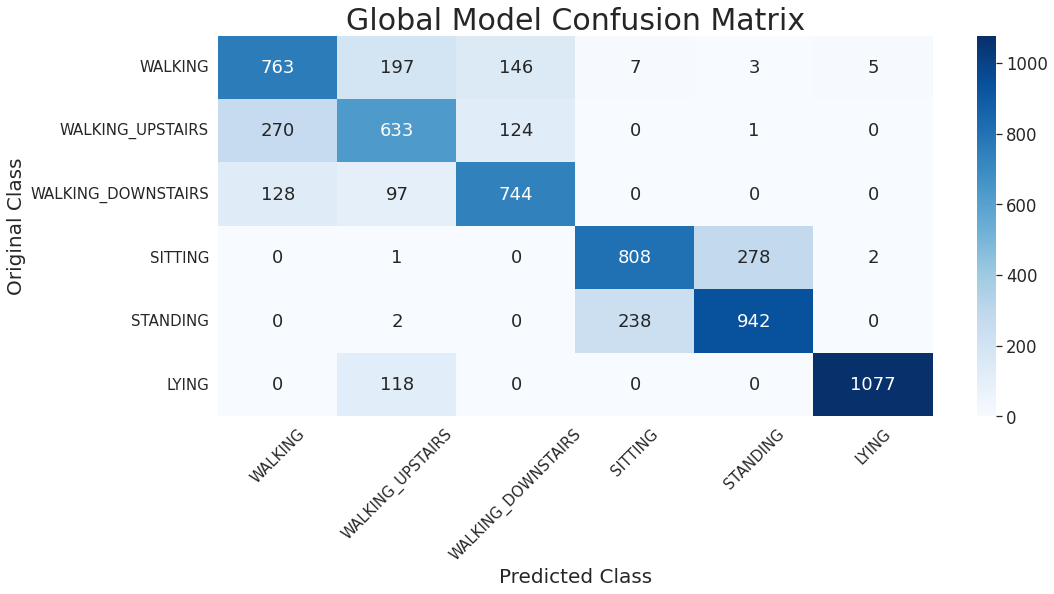

In [18]:
CONFUSION_MATRIX(y_test,y_pred)

In [19]:
from sklearn.metrics import f1_score
f1= f1_score(y_test, y_pred, average='micro')
print('f1-score %.2f'%(f1))

f1-score 0.75
